In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
import functools as ft
import optax
import treex as tx
from sdf_jax.util import plot2d
from models import IGRModel

# Implicit Geometric Regularization

"Implicit Geometric Regularization for Learning Shapes"
Gropp et al. ICML 2020
https://arxiv.org/abs/2002.10099


![](igr_loss.png)

In [2]:
def sample_normal_per_point(key, xs, local_sigma=0.01):
    key, key_local, key_global = jrandom.split(key, 3)
    sample_local = xs + jrandom.normal(key_local, xs.shape) * local_sigma
    sample_global = jrandom.uniform(key_global, (xs.shape[0]//8, xs.shape[1]))
    return jnp.vstack([sample_local, sample_global])

def surface_loss_fn(model, x):
    return jnp.abs(model(x))

def eikonal_loss_fn(model, x):
    return (jnp.linalg.norm(jax.grad(model)(x)) - 1.0)**2

@ft.partial(jax.value_and_grad, has_aux=True)
def loss_fn(params, model, xs, lam, key):
    model = model.merge(params)
    surface_loss = jnp.mean(jax.vmap(ft.partial(surface_loss_fn, model))(xs))
    xs_eik = sample_normal_per_point(key, xs)
    eikonal_loss = jnp.mean(jax.vmap(ft.partial(eikonal_loss_fn, model))(xs_eik))
    loss = surface_loss + lam * eikonal_loss
    return loss, model

@jax.jit
def train_step(model, xs, lam, optimizer, key):
    params = model.filter(tx.Parameter)
    (loss, model), grads = loss_fn(params, model, xs, lam, key)
    new_params = optimizer.update(grads, params)
    model = model.merge(new_params)
    return loss, model, optimizer

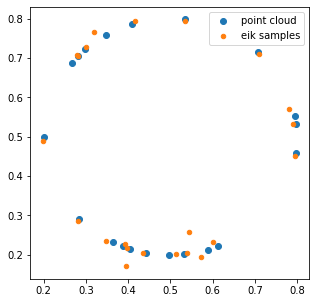

In [3]:
def sample_circle(key, nsamples=20, radius=0.3, center=jnp.array([0.5, 0.5])):
    key, theta_key = jrandom.split(key, 2)
    theta = 2 * jnp.pi * jrandom.uniform(theta_key, (nsamples,))
    xs = center + radius * jnp.vstack([jnp.cos(theta), jnp.sin(theta)]).T
    return xs

key = jrandom.PRNGKey(0)
xs = sample_circle(key)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(*xs.T, label="point cloud")
ax.scatter(*sample_normal_per_point(key, xs).T, s=20, label="eik samples")
ax.legend();

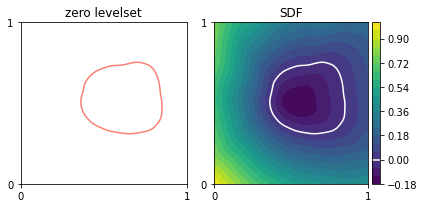

In [4]:
key = jrandom.PRNGKey(42)
key, model_key = jrandom.split(key, 2)
init_model = IGRModel(input_dim=2, depth=7, hidden=64, radius_init=0.5).init(model_key, inputs=xs[0])
plot2d(init_model, ngrid=50)

## Fit

(20, 2)


  0%|          | 0/100 [00:00<?, ?it/s]

[0] loss: 0.20147301
[10] loss: 0.04257188
[20] loss: 0.01362924
[30] loss: 0.01061821
[40] loss: 0.00891121
[50] loss: 0.01432958
[60] loss: 0.00753830
[70] loss: 0.00996181
[80] loss: 0.00944175
[90] loss: 0.01533688
[99] loss: 0.00524184


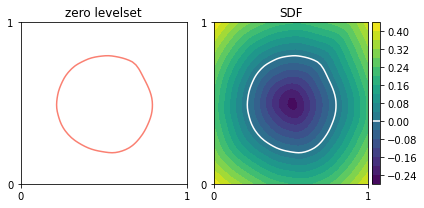

In [5]:
from models import softplus

def print_callback(step, loss, model, optimizer):
    print(f"[{step}] loss: {loss:.8f}")

def fit(
    xs,
    # module
    depth=7,
    hidden=64,
    act=softplus,
    radius_init=1.0,
    lam=1.0,
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=100,
    # utils
    cb=print_callback,
    cb_every=10,
):
    key, model_key = jrandom.split(key, 2)
    model = IGRModel(
        input_dim=2, depth=depth, hidden=hidden, act=act, radius_init=radius_init,
    ).init(model_key, xs[0])
    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    for step in tqdm(range(steps)):
        key, step_key = jrandom.split(key, 2)
        loss, model, optimizer = train_step(model, xs, lam, optimizer, step_key)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    cb(step, loss, model, optimizer)
    return loss, model

key = jax.random.PRNGKey(42)
xs = sample_circle(key)
print(xs.shape)
loss, model = fit(xs, steps=100, cb_every=10, act=softplus, lam=0.1, radius_init=0.5, key=key)
fig = plot2d(model, ngrid=50)
fig

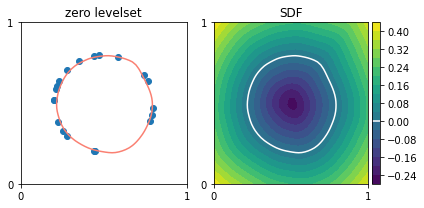

In [6]:
fig = plot2d(model, ngrid=50)
ax0 = fig.axes[0]
ax0.scatter(*xs.T)
fig

## Star

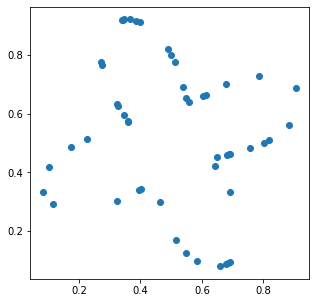

In [7]:
def sample_star(key, nsamples=50, center=jnp.array([0.5, 0.5]), corners=4):
    theta = 2 * jnp.pi * jrandom.uniform(key, (nsamples,))
    radius = 0.3 + 0.15 * jnp.sin(corners*theta)
    xs = jax.vmap(lambda r, x: center + r * x)(radius, jnp.vstack([jnp.cos(theta), jnp.sin(theta)]).T)
    return xs

key = jrandom.PRNGKey(0)
key, xs_key = jrandom.split(key, 2)
xs = sample_star(xs_key)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(*xs.T, label="point cloud")

  0%|          | 0/1000 [00:00<?, ?it/s]

[0] loss: 0.19506262
[100] loss: 0.00802162
[200] loss: 0.00643721
[300] loss: 0.00855592
[400] loss: 0.01092513
[500] loss: 0.00693366
[600] loss: 0.00898025
[700] loss: 0.00491358
[800] loss: 0.00474069
[900] loss: 0.00893564
[999] loss: 0.00272095


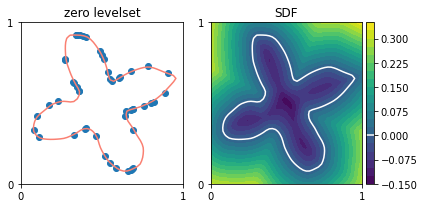

In [8]:
loss, model = fit(xs, steps=1000, cb_every=100, act=softplus, lam=0.1, radius_init=0.5, key=key)
fig = plot2d(model, ngrid=50)
ax0 = fig.axes[0]
ax0.scatter(*xs.T)
fig